In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import maketab as mt

In [17]:
# Define the MLP class (must match the original definition)
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [18]:
# Load the checkpoint
checkpoint = torch.load('model_checkpoint.pth')

# Extract architecture parameters
seq_length = checkpoint['seq_length']
num_layers = checkpoint['num_layers']
starting_point = checkpoint['starting_point']
input_size = checkpoint['input_size']
hidden_size = checkpoint['hidden_size']
output_size = checkpoint['output_size']

# Instantiate the model
model = MLP(input_size, hidden_size, output_size)

# Load the state dictionary
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
def eval(model, data):
    model.eval()
    with torch.no_grad():
        
        input_data = data[0]
        output_data = data[1]
        time_data = data[2]
        for i in range(starting_point, len(input_data) - seq_length, seq_length):
            x = input_data[i:i + seq_length]
            t = time_data[i:i + seq_length]
            y = output_data[i:i + seq_length]

            slope2, slope, intercept = np.polyfit(t, x, 2)
            mean = np.mean(x)
            std = np.std(x)
            slope = slope*10**(5)
            slope2 = slope2*10**(8)
            std = std*10**(1)
            X = torch.tensor((slope2, slope, intercept, mean, std), dtype=torch.float32)
            pred = model(X).numpy()
            reg = 10**(-8)*pred[0]*t**2 + 10**(-5)*pred[1]*t + pred[2]
            
            
            plt.plot(t, x, c='blue')
            plt.plot(t, y, c='red')
            plt.plot(t, reg, c='green')
            plt.errorbar(t[0], pred[3], pred[4], linestyle='None')
            
        plt.show()

Evaluating on test data...


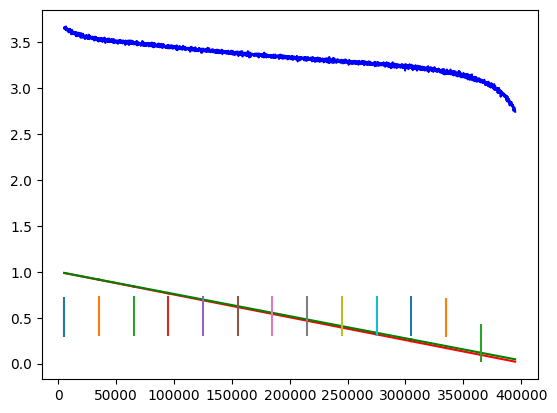

In [22]:
# Load your test data (replace this with your actual data loading code)
def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)
    return signal, tleft, t

test_data = load_data('data/5-2-25/')

# Evaluate the model on the test data
print("Evaluating on test data...")
eval(model, test_data)